In [1]:
from libraries import lib
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from libraries.NeuralStates import *

In [2]:
def log_amp_phase(nn_output):
    return torch.exp(nn_output[:, 0] + 1.j * nn_output[:, 1])
def bitflip_x(x, N, flips):
    new_x = x
    for _ in range(flips):
        new_x = x ^ (1 << npr.randint(0, N))
    return new_x

In [3]:
def set_gradients(sampled_vector: MHNeuralState, N, J, Gamma, model: nn.Sequential): # also only for log(amp), phase
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output
    def output_to_log(x):
        return x[0] + 1.j * x[1]

    elocs = {}
    re_grad_logs = {}
    im_grad_logs = {}
    params = [p for p in model.parameters()]
    for basis_state in sampled_vector.distribution:
        eloc = 0
        nn_output = sampled_vector.nn_output[basis_state]
        for adjacency in lib.generate_adjacencies(basis_state, N):
            nn_output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_to_log(nn_output_prime) - output_to_log(nn_output))
        elocs[basis_state] = eloc.detach()
        
        nn_output[0].backward(retain_graph=True)
        real_grads = [p.grad.clone() for p in params]
        for p in params: p.grad = None
        nn_output[1].backward(retain_graph=True)
        imag_grads = [-p.grad.clone() for p in params]
        re_grad_logs[basis_state] = real_grads
        im_grad_logs[basis_state] = imag_grads

    E_eloc = (sum(sampled_vector.distribution[x] * elocs[x] for x in sampled_vector.distribution) / sampled_vector.samples).real

    for i in range(len(params)):
        E_grad_times_loc = sum((re_grad_logs[x][i] * elocs[x].real - im_grad_logs[x][i] * elocs[x].imag) * \
                               sampled_vector.distribution[x] for x in sampled_vector.distribution) / sampled_vector.samples
        E_grad = sum(re_grad_logs[x][i] * sampled_vector.distribution[x] for x in sampled_vector.distribution) / sampled_vector.samples
        params[i].grad = E_grad_times_loc - E_grad * E_eloc

    return E_eloc

def set_gradients_exact(sampled_vector: MHNeuralState, N, J, Gamma, model: nn.Sequential): # also only for log(amp), phase
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output
    def output_to_log(x):
        return x[0] + 1.j * x[1]

    elocs = {}
    re_grad_logs = {}
    im_grad_logs = {}
    amp = 0
    params = [p for p in model.parameters()]
    for basis_state in sampled_vector.values:
        eloc = 0
        nn_output = sampled_vector.nn_output[basis_state]
        for adjacency in lib.generate_adjacencies(basis_state, N):
            nn_output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_to_log(nn_output_prime) - output_to_log(nn_output))
        elocs[basis_state] = eloc.detach()
        
        nn_output[0].backward(retain_graph=True)
        real_grads = [p.grad.clone() for p in params]
        for p in params: p.grad = None
        nn_output[1].backward(retain_graph=True)
        imag_grads = [-p.grad.clone() for p in params]
        re_grad_logs[basis_state] = real_grads
        im_grad_logs[basis_state] = imag_grads

        amp += abs(sampled_vector.values[basis_state]) ** 2

    E_eloc = (sum(abs(sampled_vector.values[x])** 2 * elocs[x] for x in sampled_vector.values) / amp).real

    for i in range(len(params)):
        E_grad_times_loc = sum((re_grad_logs[x][i] * elocs[x].real - im_grad_logs[x][i] * elocs[x].imag) * \
                                abs(sampled_vector.values[x]) ** 2 for x in sampled_vector.values) / amp
        E_grad = sum(re_grad_logs[x][i] * abs(sampled_vector.values[x]) ** 2 for x in sampled_vector.values) / amp
        params[i].grad = E_grad_times_loc - E_grad * E_eloc

    return E_eloc

def update_gradients(model, lr):
    with torch.no_grad():
        for p in model.parameters():
            p -= lr * p.grad 


In [26]:
N=40; J=1; Gamma=1
true_gse = lib.ground_state_energy(Gamma, N)
print(true_gse)

-50.94267411425691


In [52]:
num_epochs = 100
data_rate = 1
num_samples = 2048

In [53]:
layers = []
layers.append(nn.Linear(N, 32))
for _ in range(2):
    layers.append(nn.Linear(32, 32))
    layers.append(nn.SELU())
layers.append(nn.Linear(32, 2))
model = nn.Sequential(*layers)

In [54]:
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 0.2)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    optimizer.zero_grad()
    # energy = set_gradients(mh_state, N, J, Gamma, model)
    energy = set_gradients_exact(mh_state, N, J, Gamma, model)
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy)
print(energy_data[-1])
print(min(energy_data))

0 tensor(-41.0038, grad_fn=<SelectBackward0>)
1 tensor(-41.3905, grad_fn=<SelectBackward0>)
2 tensor(-41.0269, grad_fn=<SelectBackward0>)
3 tensor(-38.5748, grad_fn=<SelectBackward0>)
4 tensor(-40.0993, grad_fn=<SelectBackward0>)
5 tensor(-40.1064, grad_fn=<SelectBackward0>)
6 tensor(-43.6500, grad_fn=<SelectBackward0>)
7 tensor(-28.7126, grad_fn=<SelectBackward0>)
8 tensor(nan, grad_fn=<SelectBackward0>)
9 tensor(nan, grad_fn=<SelectBackward0>)
10 tensor(nan, grad_fn=<SelectBackward0>)
11 tensor(nan, grad_fn=<SelectBackward0>)
12 tensor(nan, grad_fn=<SelectBackward0>)
13 tensor(nan, grad_fn=<SelectBackward0>)
14 tensor(nan, grad_fn=<SelectBackward0>)
15 tensor(nan, grad_fn=<SelectBackward0>)
16 tensor(nan, grad_fn=<SelectBackward0>)
17 tensor(nan, grad_fn=<SelectBackward0>)
18 tensor(nan, grad_fn=<SelectBackward0>)
19 tensor(nan, grad_fn=<SelectBackward0>)
20 tensor(nan, grad_fn=<SelectBackward0>)
21 tensor(nan, grad_fn=<SelectBackward0>)
22 tensor(nan, grad_fn=<SelectBackward0>)
23 t

KeyboardInterrupt: 

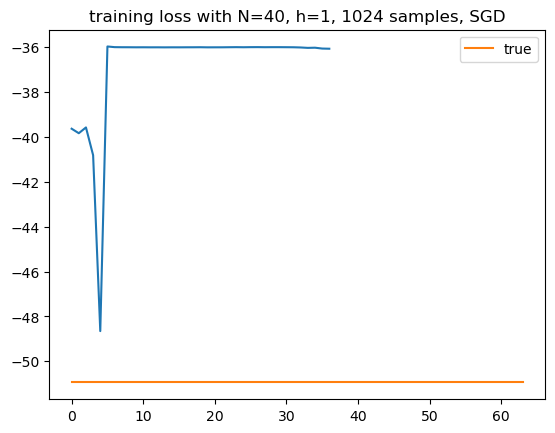

In [48]:
plt.plot(epochs, energy_data)
plt.plot([0, epochs[-1]], 2*[true_gse], label = 'true')
plt.legend(loc='best')
plt.title(f'training loss with N={N}, h={Gamma}, {num_samples} samples, SGD')
plt.show()

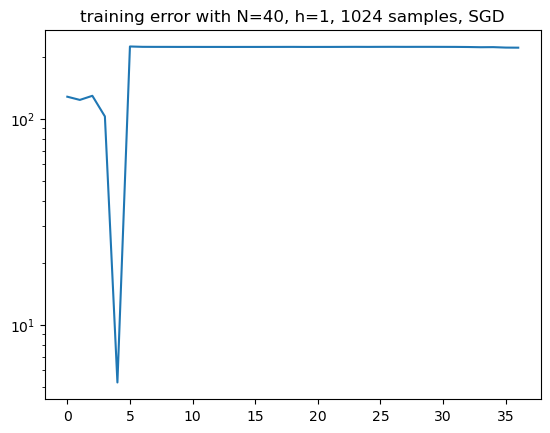

In [49]:
err = (np.array(energy_data) - true_gse) ** 2
plt.plot(epochs, err)
plt.title(f'training error with N={N}, h={Gamma}, {num_samples} samples, SGD')
plt.yscale('log')
plt.show()